### Comparison of the coherence metric between the original and surrogate data

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import seaborn               as     sns
from   tqdm                  import tqdm
from   xfrites.conn.conn_coh import conn_coherence_wav

from GDa.session             import session_info, session
from GDa.signal.surrogates   import phase_rand_surrogates

#### Loading data - for correct task trials

In [2]:
# Instantiate class
s = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
            slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
# Read data from .mat files
s.read_from_mat()

In [3]:
idx  = s.trial_info[(s.trial_info['trial_type']==1.0) \
                    & (s.trial_info['behavioral_response']==1.0)].trial_index.values

In [4]:
data = s.data.sel(trials=idx).isel(roi=[47,48])

#### Generate surrogates

In [5]:
seeds     = np.arange(0, 10, dtype=int) * 100

data_surr = []
for seed in tqdm( seeds ):
    data_surr += [phase_rand_surrogates(data,val=0,seed=seed,verbose=False,n_jobs=-1)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:05<00:51,  5.73s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:06<00:24,  3.06s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 30%|███       | 3/10 [00:08<00:16,  2.30s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 40%|████      | 4/10 [00:09<00:11,  1.89s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [00:11<00:08,  1.72s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [00:12<00:06,  1.61s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [00:13<00:04,  1.48s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [00:14<00:02,  1.41s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [00:16<00:01,  1.36s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [6]:
data_surr = xr.concat(data_surr, dim="seeds")

#### Computing coherence

In [7]:
sm_times = 300
sm_freqs = 1
# Downsampling factor
delta = 15       
mode  = 'multitaper'
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])
n_freqs      = 100
freqs        = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles     = freqs/2
decim_at     ='tfd'

In [8]:
# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=data.time, roi=None, foi=foi, n_jobs=-1,
    sfreq=data.attrs['fsample'], mode=mode, n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=2, decim_at=decim_at
)

In [9]:
coh      = conn_coherence_wav(data, **kw).astype(np.float32)

WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [10]:
coh_surr = []
for i in tqdm( range(10) ):
    coh_surr += [conn_coherence_wav(data_surr.isel(seeds=i), **kw).astype(np.float32)]
coh_surr = xr.concat(coh_surr, dim="seeds")

  0%|          | 0/10 [00:00<?, ?it/s]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:23<03:31, 23.46s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:46<03:05, 23.14s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.7s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 30%|███       | 3/10 [01:09<02:40, 22.99s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 40%|████      | 4/10 [01:31<02:17, 22.86s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [01:54<01:54, 22.91s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [02:17<01:30, 22.69s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [02:40<01:08, 22.82s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [03:03<00:45, 22.97s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.7s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [03:27<00:23, 23.31s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=100, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.0s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    8.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

100%|██████████| 10/10 [03:51<00:00, 23.18s/it]


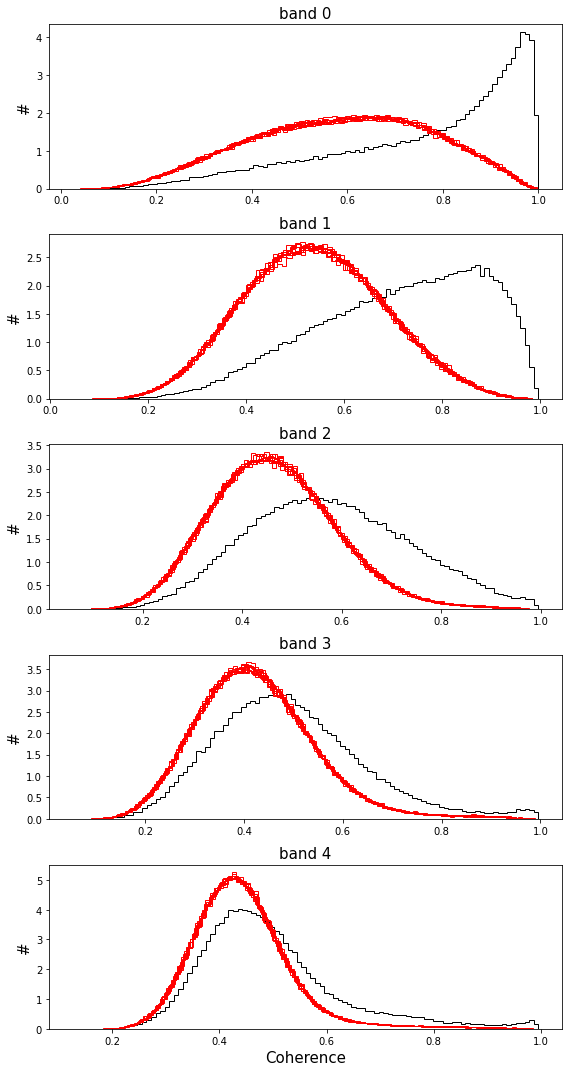

In [11]:
plt.figure(figsize=(8,15))
count = 1
for i in range(5):
    plt.subplot(5,1,count)
    plt.hist( coh.isel(freqs=i).values.flatten(), bins=100,  density=True, histtype='step', fill=False, color='k');
    plt.title(f'band {i}', fontsize=15)
    plt.ylabel('#', fontsize=15)
    for j in range(10):
        plt.hist( coh_surr.isel(seeds=j,freqs=i).values.flatten(), bins=100, density=True, histtype='step', fill=False, color='r');
    count += 1
plt.xlabel('Coherence', fontsize=15)
plt.tight_layout()

In [13]:
s.data.roi

<xarray.DataArray 'roi' (roi: 49)>
array(['a46V', 'a24c', 'a46D', 'F7', 'a9/46D', 'a8M', 'a8r', 'a8M', 'F2', 'F2',
       'a44', 'F2', 'a8L', 'F2', 'F2', 'F1', 'a3', 'F1', 'F1', 'F1', 'a3',
       'a7B', 'a7B', 'a7B', 'Thal', 'a3', 'a7B', 'a7A', 'LIP', 'LIP', 'a5',
       'a5', 'a5', 'a7A', 'a5', 'MT', 'DP', 'DP', 'V6A', 'DP', 'V2', 'V6A',
       'V1', 'V1', 'V1', 'V2', 'V1', 'V1', 'V1'], dtype='<U13')
Coordinates:
  * roi      (roi) <U13 'a46V' 'a24c' 'a46D' 'F7' ... 'V2' 'V1' 'V1' 'V1'